# FEIS Dataset - Transduction

## Load Dataset

In [29]:
from lib import FEISDataset

# Participant
pt       = "01\\"

# EEG Path
root_dir = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\experiments\\"
root_dir += pt
csv_path = root_dir + "stimuli.csv"

# Audio Path
audio_dir  = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\wavs\\"
audio_dir  += pt
audio_dir  += "combined_wavs\\"

dataset = FEISDataset(csv_path=csv_path, audio_dir=audio_dir)

In [44]:
example_idx = 0

dataset[example_idx]

{'label': 'goose',
 'audio_raw': array([-1.44888063e-07,  1.64976802e-07, -1.79901090e-07, ...,
        -6.36455455e-06,  2.58709041e-05,  5.69648720e-06]),
 'audio_feats': array([[-11.506246 , -11.511651 , -11.510628 , ..., -11.512603 ,
         -11.512728 , -11.512871 ],
        [-11.499132 , -11.510148 , -11.510438 , ..., -11.512479 ,
         -11.5125475, -11.512905 ],
        [-11.508287 , -11.504744 , -11.449142 , ..., -11.512265 ,
         -11.512279 , -11.512864 ],
        ...,
        [-11.496371 , -11.504329 , -11.476278 , ..., -11.5123005,
         -11.512506 , -11.512892 ],
        [-11.503679 , -11.512364 , -11.511157 , ..., -11.512687 ,
         -11.512702 , -11.512904 ],
        [-11.49732  , -11.49896  , -11.47645  , ..., -11.512561 ,
         -11.512614 , -11.512877 ]], dtype=float32),
 'eeg_raw': array([[ -33.13721772, -177.09535527, -151.38093397, ..., -129.64179718,
         -223.94074359,  -60.91551943],
        [ -30.35089242, -174.87661531, -158.82941148, ..., -1

## Data Visualisation

### Raw EEG (Drift Removed)

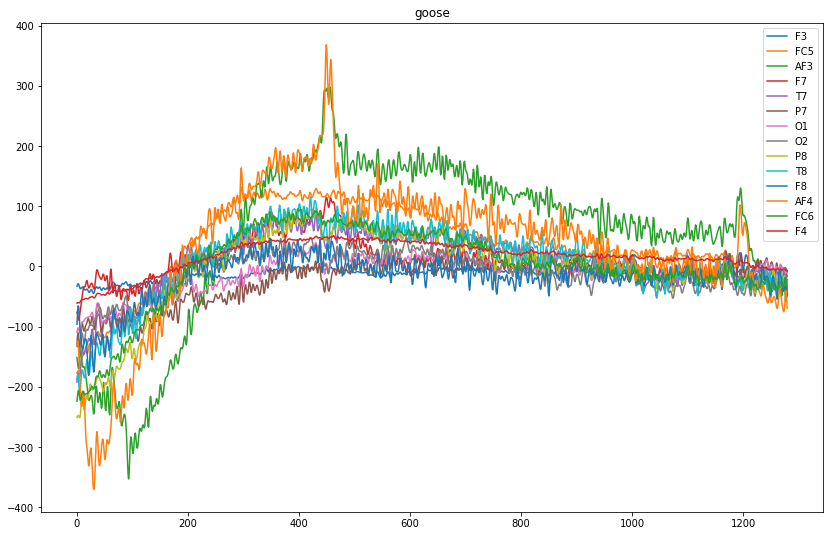

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

eeg_data = dataset[example_idx]["eeg_raw"]
plt.title(dataset[example_idx]["label"])
for i in range(eeg_data.shape[1]):
    cur_channel = eeg_data[:, i]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### EEG Features (Digital Voicing)

eeg_feats.shape: (425, 70)


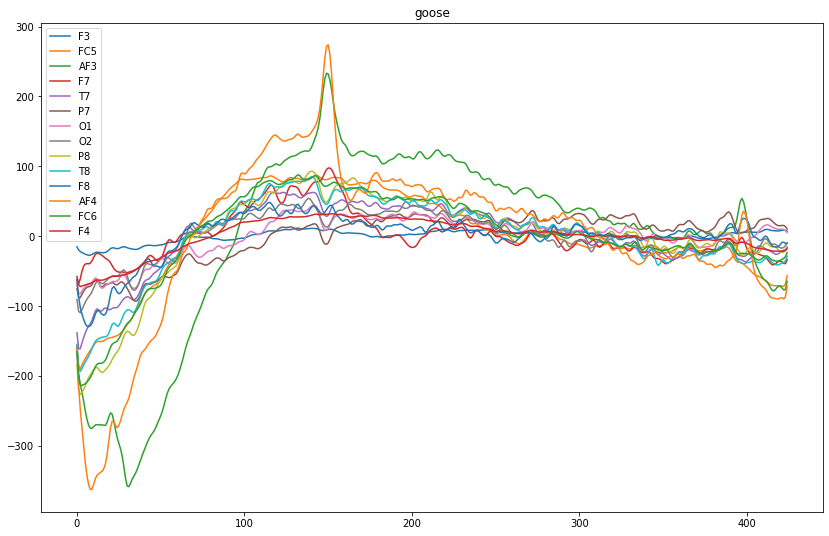

In [32]:
eeg_data = dataset[example_idx]["eeg_feats"]
plt.title(dataset[example_idx]["label"])
print("eeg_feats.shape:", eeg_data.shape)
for i in range(len(dataset.channels)):
    cur_channel = eeg_data[:, (i*5)+0]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### Raw Audio

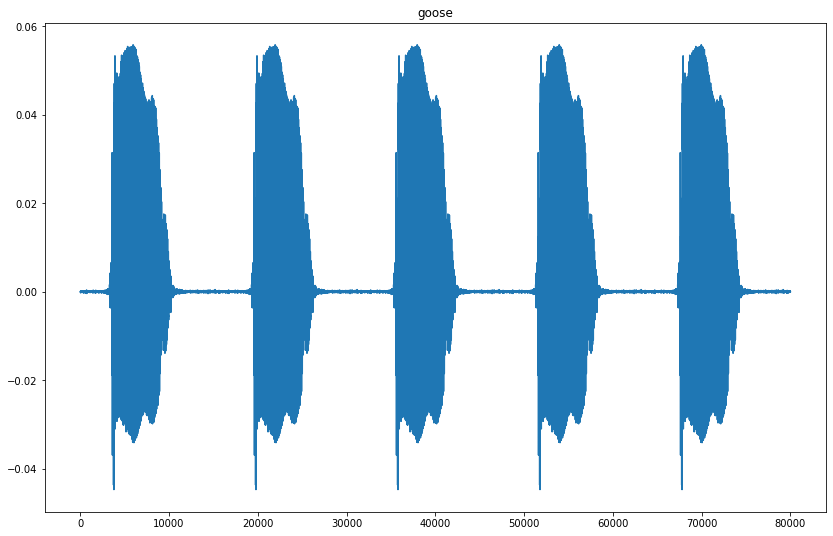

In [33]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)
plt.title(dataset[example_idx]["label"])
plt.plot(dataset[example_idx]["audio_raw"])

### Plot Audio Features (Mel Spectrogram)

In [34]:
import numpy as np
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

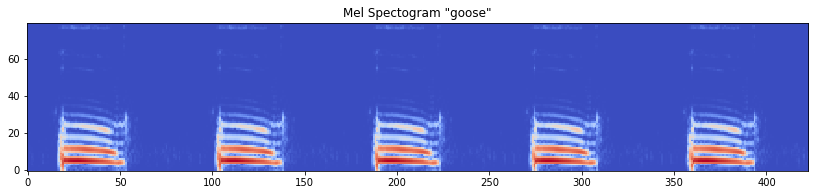

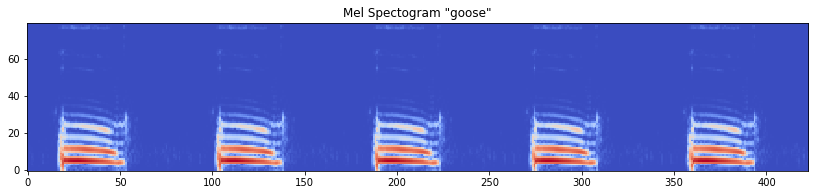

In [35]:
example_mel_spec = dataset[example_idx]["audio_feats"]
plot_mel_spectrogram(example_mel_spec, dataset[example_idx]["label"])

In [36]:
print(set(dataset.labels))

{'n', 'p', 'zh', 'ng', 'm', 'thought', 'z', 'v', 'k', 'sh', 'trap', 'f', 's', 'goose', 't', 'fleece'}


## Single Synthesis (Overfit)

### Model

In [37]:
import torch.nn as nn
import torch.nn.functional as F

from lib.transformer import *

class ProposedModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        # Transformer
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

In [55]:
import torch
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

ins = dataset.num_features
outs = 80 # mel bins
model = ProposedModel(\
        model_size=ins,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs).to(device)

### Training

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

synth_example = dataset[example_idx]

X = torch.tensor(synth_example["eeg_feats"],   dtype=torch.bfloat16).to(device)
y = torch.tensor(synth_example["audio_feats"], dtype=torch.bfloat16).to(device)

clip_len = min(X.shape[0], y.shape[0])

X = X[:clip_len, :ins]
y = y[:clip_len, :]

print("X SHAPE, Y SHAPE:", X.shape, y.shape)

X = torch.unsqueeze(X, 0)
y = torch.unsqueeze(y, 0)

lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

for i in range(epochs):
    #optim.zero_grad()

    with torch.autocast(
        enabled=amp,
        dtype=torch.bfloat16,
        device_type=device):

        #print("model inp:", X.shape, X.dtype)

        pred = model(X)

        #print("model outp:", pred.shape, pred.dtype)

        if y.shape[1] < pred.shape[1]:
            pred = pred[:, :y.shape[1], :]
            #print("model outp (clipped):", pred.shape, pred.dtype)
            #print("y:", y.shape)

        loss = criteria(pred, y)

        if i % 100 == 0:
            pred_s.append(pred.cpu().detach())
            losses.append(loss.item())

        # plt.plot(loss.item())

            print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

X SHAPE, Y SHAPE: torch.Size([423, 70]) torch.Size([423, 80])
0 120.327392578125
100 46.047794342041016
200 10.789039611816406
300 2.9748358726501465
400 2.290374279022217
500 1.3607977628707886
600 0.8768020868301392
700 0.5516628623008728
800 0.36957547068595886
900 0.28120186924934387
1000 0.2209516018629074
1100 0.18690012395381927
1200 0.15421141684055328
1300 0.129182368516922
1400 0.11054760962724686
1500 0.09806033968925476
1600 0.08615529537200928
1700 0.06871846318244934
1800 0.06544139981269836
1900 0.05857058987021446
2000 0.049233973026275635
2100 0.04434122517704964
2200 0.03883904218673706
2300 0.03566829115152359
2400 0.036879368126392365
2500 0.0307734664529562
2600 0.02765633352100849
2700 0.030392087996006012
2800 0.027896791696548462
2900 0.02170712500810623
3000 0.024357449263334274
3100 0.0221731998026371


KeyboardInterrupt: 

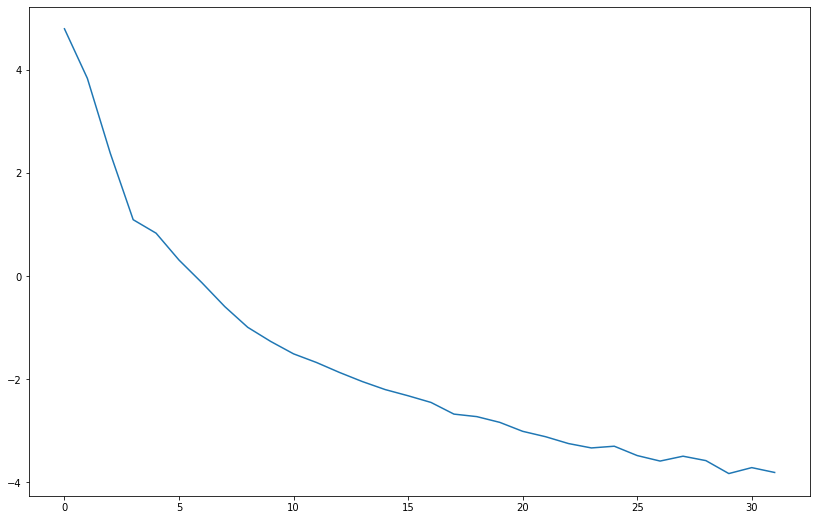

In [57]:
plt.plot(np.log(losses))

### Plot Pred

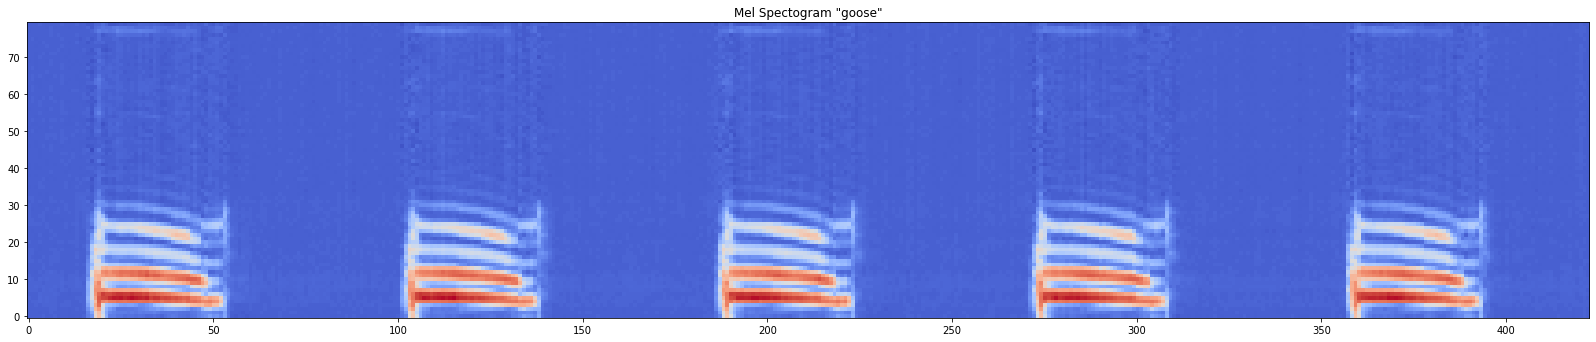

In [60]:
plt.rcParams["figure.figsize"] = (14*2, 9*2)

y = torch.squeeze(pred_s[len(pred_s) - 1], 0).float()
_ = plot_mel_spectrogram(y, synth_example["label"])

### Plot Original

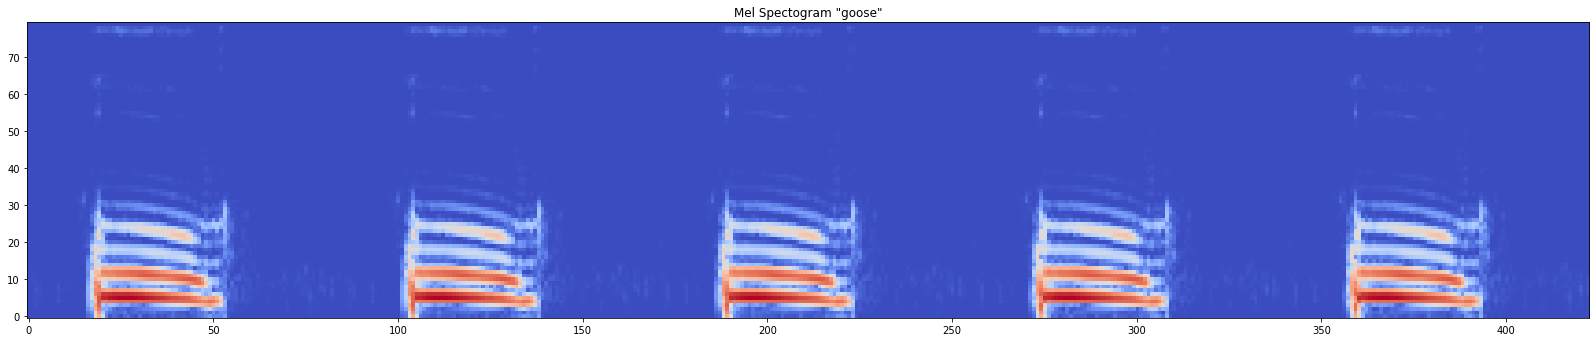

In [61]:
cur_ex = dataset[example_idx]
_ = plot_mel_spectrogram(cur_ex["audio_feats"], cur_ex["label"])